# **1. Data Preprocessing**

## **1.1 Import Data**

In [ ]:
import pandas as pd
import json
import requests
import io
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab.patches import cv2_imshow



In [ ]:
#! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1LcKqf1d7bctw5lx0YZf31kCUF0zEYOsi'
downloaded = drive.CreateFile({'id': file_id})

downloaded.GetContentFile('MNIST_synthetic.zip')

In [ ]:
from zipfile import ZipFile
file_name = "MNIST_synthetic.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 
dataset = h5py.File('MNIST_synthetic.h5', 'r')

File Name                                             Modified             Size
MNIST_synthetic.h5                             2020-11-21 00:57:46    287842048
Extracting all the files now...
Done!


In [ ]:
#winnie
print(dataset['test_dataset'].shape)
print(dataset['train_dataset'].shape)
print(dataset['train_labels'].shape)


X_test_0=dataset['test_dataset'].value
X_train_0=dataset['train_dataset'].value
y_train_0=dataset['train_labels'].value

(14000, 64, 64, 1)
(56000, 64, 64, 1)
(56000, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


## **1.2 Data Preprocessing**





### **1.2.1 Image Cropping and resize**


*  openCV
*  Resizee



In [ ]:
def get_contour(img):
  # convert img to openCv object
  im2 = np.uint8(img)
  threshold_level = 0 # Set threshold
  net, thresh = cv2.threshold(im2, threshold_level, 255, cv2.THRESH_BINARY)
  # find contours
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours
################################################################################
# Function2: order of subgraph
def cropped_image(contours,img):
  cropped_scale=[]
  x1_x2_len=[]
  # total number of digits in a graph
  for contour_line in contours:
    x, y = [], []
    for contour in contour_line:
      x.append(contour[0][0])
      y.append(contour[0][1])

    x1, x2, y1, y2 = min(x)-1, max(x)+1, min(y)-1, max(y)+1
    if x1 == x2 or y1 ==y2:
      continue
    elif max(y)-min(y)<=5:
      continue

    else:
      cropped_scale.append([x1,x2,y1,y2])
    if len(cropped_scale)>5:
      #x1_x2_len=[cropped_scale[i][1]-cropped_scale[i][0]  for i in range(len(cropped_scale))]
      #cropped_scale_new= cropped_scale.sort(key=(lambda x: x[0]-x[1]) )
      #cropped_scale_new.sort()
      cropped_scale.sort(key=(lambda x: x[0]-x[1]) )
      cropped_scale=cropped_scale[0:5]


  cropped_scale.sort()

  return cropped_scale
################################################################################
# Function 4: image resize
def image_resize(img,cropped_scale,w,h):
  image=np.zeros((5,w,h))
  dim = (w, h)
  for i in range(len(cropped_scale)):
    x1, x2, y1, y2 = cropped_scale[i][0],cropped_scale[i][1],cropped_scale[i][2],cropped_scale[i][3]
    cropped = img[y1:y2, x1:x2]
    resize_image = cv2.resize(cropped, dim, interpolation=cv2.INTER_LINEAR)
    image[i]=resize_image
    cv2_imshow(resize_image)
  return image




In [ ]:
# winnie
import cv2 
import numpy as np
# the first image  
img=X_train_0[0]
################################################################################
# Function1: get image contour

def get_signal(img,index):
  length=0
  signal=-1
  for j in img[:,index]:
      if j[0]>0:
          length=length+1
          if length>7:
              signal=1
              break
  return signal


def get_contour_new(img):
  standard=np.zeros((64,1))
  cropped_scale=[]
  x1_x2_len=[]
  x=[]
  ptr=0
  acc=0
  for i in range(64):
    if [False] not in (img[:,i]==standard):
      x.append(i)
     
  for i in range(len(x)-1):
    if x[i]+1 != x[i+1]:

      if x[i+1]-x[i]==3:
        for j in range(2):
          if get_signal(img,x[i]+j)==1:
            x1,x2,y1,y2=x[i]-1,x[i+1]+1,25,38
            cropped_scale.append([x1,x2,y1,y2])
            break
      if x[i+1]-x[i]==4:
        for j in range(3):
          if get_signal(img,x[i]+j)==1:
            x1,x2,y1,y2=x[i]-1,x[i+1]+1,25,38
            cropped_scale.append([x1,x2,y1,y2])
            break


            
      elif x[i+1]-x[i]>3:
          x1,x2,y1,y2=x[i]-1,x[i+1]+1,25,38
          cropped_scale.append([x1,x2,y1,y2])

  if len(cropped_scale)>5:
      #x1_x2_len=[cropped_scale[i][1]-cropped_scale[i][0]  for i in range(len(cropped_scale))]
      #cropped_scale_new= cropped_scale.sort(key=(lambda x: x[0]-x[1]) )
      #cropped_scale_new.sort()
      cropped_scale.sort(key=(lambda x: x[0]-x[1]) )
      cropped_scale=cropped_scale[0:5]

  cropped_scale.sort()
  return cropped_scale


    




################################################################################
 # Function3: show cropped image
def show_cropped_image(img,cropped_scale):
  cv2_imshow(img)
  for i in range(len(cropped_scale)):
    x1, x2, y1, y2 = cropped_scale[i][0],cropped_scale[i][1],cropped_scale[i][2],cropped_scale[i][3]
    cropped = img[y1:y2, x1:x2]
    # function showing the image
    cv2_imshow(cropped)


################################################################################
# Function 5: new image resize
def resize(x1,x2,y1,y2,img,w,h):
  
  image=np.zeros((0,w))
  h0=(h-(y2-y1))
  w0=(w-(x2-x1))
  #print(h0)
  #print(img.shape)
  if h0%2!=0:
    h_diff=int(float(h0)/2)
    a=np.zeros((h_diff,w))
    image=np.append(image,np.zeros((h_diff,w)),axis=0)
    if w0%2 !=0:
      w_diff=int(float(w0)/2)
      #print(np.zeros((y2-y1,w_diff)).shape)
      #print(img[y1:y2, x1:x2].shape)
      tmp=np.append(np.zeros((y2-y1,w_diff)),img[y1:y2, x1:x2],axis=1)
      #print(tmp.shape,np.zeros((y2-y1,w_diff+1)).shape)
      tmp=np.append(tmp,np.zeros((y2-y1,w_diff+1)),axis=1 )
      #print(tmp.shape)
      image=np.append(image,tmp,axis=0)
      image=np.append(image,np.zeros((h_diff+1,w)),axis=0)
    else:
      w_diff=int(w0/2)
      tmp=np.append(np.zeros((y2-y1,w_diff)),img[y1:y2, x1:x2],axis=1)
      tmp=np.append(tmp,np.zeros((y2-y1,w_diff)),axis=1 )
      image=np.append(image,tmp,axis=0)
      image=np.append(image,np.zeros((h_diff+1,w)),axis=0)

  else:
    h_diff=int(h0/2)
    image=np.append(image,np.zeros((h_diff,w)),axis=0)
    
    if w0%2 !=0:
    
      w_diff=int(float(w0)/2)
      tmp=np.append(np.zeros((y2-y1,w_diff)),img[y1:y2, x1:x2],axis=1)
      tmp=np.append(tmp,np.zeros((y2-y1,w_diff+1)),axis=1 )
      image=np.append(image,tmp,axis=0)
      image=np.append(image,np.zeros((h_diff,w)),axis=0)
    else:
      w_diff=int(w0/2)
      tmp=np.append(np.zeros((y2-y1,w_diff)),img[y1:y2, x1:x2],axis=1)
      tmp=np.append(tmp,np.zeros((y2-y1,w_diff)),axis=1 )
      image=np.append(image,tmp,axis=0)
      image=np.append(image,np.zeros((h_diff,w)),axis=0)
  return image



def image_resize_new(img,cropped_scale,w,h):
  tmp=np.zeros((64,64))
  for i in range(64):
    for j in range(64):
      tmp[i][j]=img[i][j][0]

  image=np.zeros((5,w,h))
  dim = (w, h)
  ptr=0
  for i in range(len(cropped_scale)):
    x1, x2, y1, y2 = cropped_scale[i][0],cropped_scale[i][1],cropped_scale[i][2],cropped_scale[i][3]
    if x2-x1>16:
      diff=int((x2-x1)/2)
      resize_image=resize(x1,x2-diff,y1,y2,tmp,w,h)
      image[ptr]=resize_image
      cv2_imshow(resize_image)
      ptr=ptr+1
      resize_image=resize(x2-diff,x2,y1,y2,tmp,w,h)
      image[ptr]=resize_image
      ptr=ptr+1
      cv2_imshow(resize_image)

    else:
      resize_image=resize(x1,x2,y1,y2,tmp,w,h)
      image[ptr]=resize_image
      ptr=ptr+1
    #cv2_imshow(resize_image)
  return image

################################################################################
# Function 6: rearrange the image
def training_resize(X_train_0,w,h,size):
  X_train_new=np.zeros((size,w,h))
  ptr=0
  for i in range(len(X_train_0)):
    if i%1000==0:
      print('iteration:',i)
    img=X_train_0[i]
    #cv2_imshow(img)
    #contours=get_contour(img)
    #cropped_scale=cropped_image(contours,img)
    cropped_scale=get_contour_new(img)
    image=image_resize_new(img, cropped_scale,w,h)
    #X_train_new=np.append(X_train_new,image,axis=0)
    for j in range(5):
      X_train_new[ptr]=image[j]
      ptr=ptr+1
  return X_train_new


    


[[28, 37, 25, 38]]


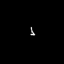

In [ ]:
#show example 
def show_edge_case(i):
  img=X_train_0[i]
  #contours=get_contour(img)
  #cropped_scale=cropped_image(contours,img)
  cropped_scale=get_contour_new(img)
  print(cropped_scale)
  #print(img[:,46])
  show_cropped_image(img,cropped_scale)
  image=image_resize_new(img, cropped_scale,16,16)
  for i in range(5):
    cv2_imshow(image[i])

show_edge_case(3530)



In [ ]:
# training dataset
# X_train_0 ==> X_train_1
X_train_1=training_resize(X_train_0[0:56000],16,16,280000)
# testing dataset
# X_test_0 ==> X_test_1
X_test_1=training_resize(X_test_0[0:14000],16,16,70000)


iteration: 0


iteration: 1000


iteration: 2000


iteration: 3000


iteration: 4000


iteration: 5000


iteration: 6000


iteration: 7000


iteration: 8000


iteration: 9000


iteration: 10000


iteration: 11000


iteration: 12000


iteration: 13000


iteration: 14000


iteration: 15000


iteration: 16000


iteration: 17000


iteration: 18000


iteration: 19000


iteration: 20000


iteration: 21000


iteration: 22000


iteration: 23000


iteration: 24000


iteration: 25000
iteration: 26000


iteration: 27000


iteration: 28000


iteration: 29000


iteration: 30000
iteration: 31000


iteration: 32000


iteration: 33000


iteration: 34000


iteration: 35000


iteration: 36000


iteration: 37000


iteration: 38000


iteration: 39000


iteration: 40000


iteration: 41000
iteration: 42000


iteration: 43000


iteration: 44000


iteration: 45000
iteration: 46000


iteration: 47000


iteration: 48000


iteration: 49000


iteration: 50000


iteration: 51000


iteration: 52000


iteration: 53000


iteration: 54000


iteration: 55000


iteration: 0
iteration: 1000


iteration: 2000


iteration: 3000


iteration: 4000


iteration: 5000


iteration: 6000


iteration: 7000


iteration: 8000


iteration: 9000


iteration: 10000


iteration: 11000


iteration: 12000


iteration: 13000


In [ ]:
length=len(y_train_0)
print(length)
a=np.zeros((length*5,1))
for i in range(length):
  a[5*i][0]=y_train_0[i][0]
  a[5*i+1][0]=y_train_0[i][1]
  a[5*i+2][0]=y_train_0[i][2]
  a[5*i+3][0]=y_train_0[i][3]
  a[5*i+4][0]=y_train_0[i][4]
print(a.shape)

56000
(280000, 1)


### **1.2.2 Data Augmentation**

In [ ]:
import argparse
import os

import numpy as np
#from PIL import Image
#from scipy.misc import imresize
from scipy.ndimage.interpolation import rotate
from scipy.ndimage import shift


#n=10000
n=0
ptr=0
indexs=np.random.randint(280000, size=n)
X_train_1_rotate=np.zeros((n,16,16))
y_train_1_rotate=np.zeros((n,1))
for index in indexs:
  if ptr%10000==0:
    print(ptr)
  degree=np.random.uniform(-22.0,22.0)
  #h=np.random.uniform(-1.0,1.0)
  #w=np.random.uniform(-1.0,1.0)
  #cv2_imshow(X_train_1[i])
  #tmp=shift(X_train_1[i],shift=(w,h))
  #cv2_imshow(tmp)
  X_train_1_rotate[ptr]=rotate(X_train_1[index],angle=degree,reshape=False)
  #cv2_imshow(X_train_1_rotate[i])
  y_train_1_rotate[ptr]=a[index]
  ptr=ptr+1



In [ ]:
X_train_1_new=np.append(X_train_1,X_train_1_rotate,axis=0)
y_train_1_new=np.append(a,y_train_1_rotate,axis=0)
print(X_train_1_new.shape)
print(y_train_1_new.shape)

(280000, 16, 16)
(280000, 1)


### **1.2.3 Normalization**

**Standardize**

In [ ]:
tmp=np.append(X_train_1_new,X_test_1,axis=0)
mean=tmp.mean()
std=tmp.std()


X_train_2=(X_train_1_new-tmp.mean())/std
X_test_2=(X_test_1-tmp.mean())/std

## **1.3 Convert from ndarray to tensor** 


For X_train, input is ndarray(56000*5,64,64,1). However, the output should be tensor(56000*5,1,64,64) that is (batch_size, #channel, image_size). What we gonna do is nparray(56000,64,64,1)==> nparray(56000,1,64,64) ==> tensor(56000,1,64,64)


**Convert training**

In [ ]:
import numpy as np
print(X_train_2.shape)
X_train=np.zeros((len(X_train_2),1,16,16))
for i in range(len(X_train)):
  X_train[i][0]=X_train_2[i]
print(X_train.shape)
N=len(X_train)


tmp_X=np.append(X_train[0:260000],X_train[270000:N],axis=0)
tmp_X=np.append(tmp_X,X_train[260000:270000],axis=0)
print(tmp_X.shape)
X_train=torch.from_numpy(tmp_X)


(280000, 16, 16)
(280000, 1, 16, 16)
(280000, 1, 16, 16)


trainging set y

In [ ]:
# convert ttaining y
tmp_y=np.append(y_train_1_new[0:260000],y_train_1_new[270000:N],axis=0)
tmp_y=np.append(tmp_y,y_train_1_new[260000:270000],axis=0)
print(tmp_y.shape)
y_train=torch.from_numpy(tmp_y)

(280000, 1)


**Convert testing**

In [ ]:
#convert x
import numpy as np
print(X_test_2.shape)
X_test=np.zeros((len(X_test_2),1,16,16))
for i in range(len(X_test)):
  X_test[i][0]=X_test_2[i]
X_test.shape

X_test=torch.from_numpy(X_test)

(70000, 16, 16)


#  **2. Building model architecture**
**Describe the proposed model and training objective for the task in detail.**
**Report the best performing model architecture and its hyper-parameter in a table in the Appendix.**
**Justify the of choice of hyper-parameters (model architecture, optimizer and its parameters) that lead to
this final model.**
**Compare and report the validation and train performance of your best performing model as a function of
training epochs.**




In [ ]:



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#import autograd.Function 

In [ ]:
!pip install pycuda
import torch 
import pycuda.driver as cuda
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda.init()
torch.cuda.current_device()
print(cuda.Device(0).name())
#net.to(device)

     |████████████████████████████████| 1.6MB 12.8MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621418 sha256=cea6e89548aa0500571bcdbe2e81ed288e9cac5ca4694fd9540688ca6713a7f8
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.4-py2.py3-none-any.whl size=59110 sha256=d1a1d8c0656e5fbcb572d6eb4cae513050aa4fbdf5cf7a19ea0bd25cf20930f4
  Stored in directory: /root/.cache/pip/wheels/6f/2a/6e/0b210d900f2b6caca133395d2fa153d8a9c03ad42c3c5d55bf
Successfully built pycuda pytools
Tesla V100-SXM2-16GB


In [ ]:
torch.cuda.empty_cache()

## **2.1 Model Height**

In [ ]:
wrong_index={}
def get_accuracy(y,y_pred,s):
  dict={}
  length=len(y)
  new_length=int(length/5)
  acc=0.0
  single_label_acc=0.0
  for i in range(new_length):
    index=5*i
    if y[index]==y_pred[index] and y[index+1]==y_pred[index+1] and y[index+2]==y_pred[index+2] and y[index+3]==y_pred[index+3] and y[index+4]==y_pred[index+4]:
      acc=acc+1
  for i in range(length):
    if y[i]==y_pred[i] :
      single_label_acc=single_label_acc+1
    else:
      '''
      print("X_train_0",(s+i)/5,"X_train_1",(s+i))
      cv2_imshow(X_train_0[int((s+i)/5)])
      cv2_imshow(X_train_1[s+i])
      print("true: ",int(y[i]),"false: ",int(y_pred[i]))
      '''
      
      if (s+i) in wrong_index:
        wrong_index[s+i]=wrong_index[s+i]+1
      else:
        wrong_index[s+i]=1
      
      
      if int(y[i]) in dict:
        dict[int(y[i])]=dict[int(y[i])]+1
      else:
        dict[int(y[i])]=1
  print("Overall accuracy: ",acc/new_length)
  print("Single label accuracy: ",single_label_acc/length)
  print(dict)

### **2.1.1 1CNN+4Dense layer**

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 2,padding=1)
        self.norm1=nn.BatchNorm2d(10)
       
        self.fc1 = nn.Linear(10 * 8 * 8, 46) 
        self.fc2 = nn.Linear(46, 46)
        self.fc3 = nn.Linear(46, 24)
        self.norm4 = nn.BatchNorm1d(24)
        self.fc4 = nn.Linear(24,11)

    def forward(self, x):
       
        # (batch_size,1,16,16) ==> (batch_size,10,17,17)==> (batch_size,10,8,8)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
  
        x=self.norm1(x)
        
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
       
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x=self.norm4(x)
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        
        return x
        #return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
import torch.optim as optim
net1=Net()

optimizer = optim.Adam(net1.parameters(), lr=0.001, weight_decay=1e-3,betas=(0.9,0.99))
criterion = nn.CrossEntropyLoss()

# divide X_train into X_valid and X_train_new

a=X_train[0:270000]
b=y_train[0:270000]

X_train_new=a
y_train_new=b.long()

batch_num=100
batch_size=int(len(y_train_new)/batch_num)

In [ ]:
net1.to(device)
input = X_train_new.cuda()

min_loss=10000000000000000

acc=0
acc_loss=0
early_stopping=0
for trial in range(5):
  for epoch in range(200000):
      # minibatch gradient descent
      loss=0.0
      for k in range(batch_num):
        l_index=batch_size*k
        r_index=batch_size*(k+1)
        out = net1(input[l_index:r_index].float().cuda())
        avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
        loss=loss+(avg_loss/batch_num)
        optimizer.zero_grad()
        avg_loss.backward()
        optimizer.step() 
        #scheduler.step()  
        learning_rate = 0.001
        for f in net1.parameters():
          f.data.sub_(f.grad.data * learning_rate)
     
      # early stopping
      if loss>=min_loss:
        acc_loss=acc_loss+1
        
        if acc_loss >=30:
          early_stopping=early_stopping+1
          #print('Early stopping！')
          break
        
      elif loss<min_loss:
        acc_loss=0
        min_loss=loss
       
      
      if epoch%100==0:
        print('trial:',trial,'epoch',epoch,':',loss)
  
  if early_stopping==1:
    print("Early Stopping trial1!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))

  if early_stopping==2:
    print("Early Stopping trial2!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
  if early_stopping==3:
    print("Early Stopping trial3!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.92))
  if early_stopping==4:
    print("End of raining!!!!!")
    break
    

trial: 0 epoch 0 : tensor(1.1898, device='cuda:0', grad_fn=<AddBackward0>)
trial: 0 epoch 100 : tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)
trial: 0 epoch 200 : tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)
Early Stopping trial1!!!
trial: 1 epoch 0 : tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)
Early Stopping trial2!!!
trial: 2 epoch 0 : tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
Early Stopping trial3!!!
trial: 3 epoch 0 : tensor(0.0039, device='cuda:0', grad_fn=<AddBackward0>)
End of raining!!!!!


In [ ]:
id=[i*10000 for i in range(29)]
wrong_index={}
for i in range (len(id)-1):
  out = net1(X_train[id[i]:id[i+1]].float().cuda())
  y_train_new=y_train[id[i]:id[i+1]].long().cuda()
  loss = criterion(out, y_train_new[:,0].cuda())
  _, predicted = torch.max(out, 1)
  get_accuracy(y_train_new[:,0],predicted,id[i])
print("Final trainning accuracy(single label):",len(wrong_index)/280000)

Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  0.9995
Single label accuracy:  0.9999
{8: 1}
Overall accuracy:  0.9995
Single label accuracy:  0.9999
{8: 1}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  0.9995
Single label accuracy:  0.9999
{2: 1}
Overall accuracy:  1.0
Single label accuracy:  1.0
{}
Overall accuracy:  0.9995
Single label accuracy:  0.

### **2.1.2 2CNN+3Dense layer**

In [ ]:
# winnie发现： linear function--nn.Linear 会让scalar越来越小
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 2,padding=1)
        self.norm1=nn.BatchNorm2d(10)
        #self.dropout1=nn.Dropout2d(p=0.02)
        self.conv2 = nn.Conv2d(10, 16, 2,padding=1)
        
        self.norm2=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 4 * 4, 46)  # 6*6 from image dimension4
        #self.norm3 = nn.BatchNorm1d(24)
        self.fc3 = nn.Linear(46, 24)
        self.norm4 = nn.BatchNorm1d(24)
        self.fc4 = nn.Linear(24,11)
      
    def forward(self, x):
       
        # (batch_size,1,16,16) ==> (batch_size,6,17,17)==> (batch_size,6,8,8)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
  
        # (batch_size,6,8,8) ==> (betach_size,16,9,9)==> (batch_size,16,4,4)
        x=self.norm1(x)
        #x=self.dropout1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # (batch_size,6,4,4) ==> (betach_size,10,5,5)==> (batch_size,10,2,2)
     
        x=self.norm2(x)
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
 
        x = F.relu(self.fc3(x))
        x=self.norm4(x)
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
       
        return x
        #return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
import torch.optim as optim
net1=Net()

optimizer = optim.Adam(net1.parameters(), lr=0.001, weight_decay=1e-3,betas=(0.9,0.99))
criterion = nn.CrossEntropyLoss()

# divide X_train into X_valid and X_train_new

a=X_train[0:270000]
b=y_train[0:270000]

X_train_new=a
y_train_new=b.long()

batch_num=100
batch_size=int(len(y_train_new)/batch_num)

In [ ]:
net1.to(device)
input = X_train_new.cuda()

min_loss=10000000000000000

acc=0
acc_loss=0
early_stopping=0
for trial in range(5):
  for epoch in range(200000):
      # minibatch gradient descent
      loss=0.0
      for k in range(batch_num):
        l_index=batch_size*k
        r_index=batch_size*(k+1)
        out = net1(input[l_index:r_index].float().cuda())
        avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
        loss=loss+(avg_loss/batch_num)
        optimizer.zero_grad()
        avg_loss.backward()
        optimizer.step() 
        #scheduler.step()  
        learning_rate = 0.001
        for f in net1.parameters():
          f.data.sub_(f.grad.data * learning_rate)
     
      # early stopping
      if loss>=min_loss:
        acc_loss=acc_loss+1
        
        if acc_loss >=30:
          early_stopping=early_stopping+1
          #print('Early stopping！')
          break
        
      elif loss<min_loss:
        acc_loss=0
        min_loss=loss
       
      
      if epoch%100==0:
        print('trial:',trial,'epoch',epoch,':',loss)
  
  if early_stopping==1:
    print("Early Stopping trial1!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))

  if early_stopping==2:
    print("Early Stopping trial2!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
  if early_stopping==3:
    print("Early Stopping trial3!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.92))
  if early_stopping==4:
    print("End of raining!!!!!")
    break

trial: 0 epoch 0 : tensor(1.2552, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

In [ ]:
id=[i*10000 for i in range(29)]
wrong_index={}
for i in range (len(id)-1):
  out = net1(X_train[id[i]:id[i+1]].float().cuda())
  y_train_new=y_train[id[i]:id[i+1]].long().cuda()
  loss = criterion(out, y_train_new[:,0].cuda())
  _, predicted = torch.max(out, 1)
  get_accuracy(y_train_new[:,0],predicted,id[i])
print("Final trainning accuracy(single label):",len(wrong_index)/280000)

## **2.2 Model width**

### 2.2.1 Large width

In [ ]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 2,padding=1)
        self.norm1=nn.BatchNorm2d(10)
        #self.dropout1=nn.Dropout2d(p=0.02)
        self.conv2 = nn.Conv2d(10, 16, 2,padding=1)
        
        self.norm2=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 4 * 4, 64)  # 6*6 from image dimension4
        self.fc5 = nn.Linear(64, 64)
        self.norm3 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 24)
        self.norm4 = nn.BatchNorm1d(24)
        self.fc4 = nn.Linear(24,11)
      
    def forward(self, x):
       
        # (batch_size,1,16,16) ==> (batch_size,6,17,17)==> (batch_size,6,8,8)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
  
        # (batch_size,6,8,8) ==> (betach_size,16,9,9)==> (batch_size,16,4,4)
        x=self.norm1(x)
        #x=self.dropout1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # (batch_size,6,4,4) ==> (betach_size,10,5,5)==> (batch_size,10,2,2)
     
        x=self.norm2(x)
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc5(x))
        x=self.norm3(x)
        x = F.relu(self.fc3(x))
        x=self.norm4(x)
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
       
        return x
        #return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
import torch.optim as optim
net1=Net()

optimizer = optim.Adam(net1.parameters(), lr=0.001, weight_decay=1e-3,betas=(0.9,0.99))
criterion = nn.CrossEntropyLoss()

# divide X_train into X_valid and X_train_new

a=X_train[0:270000]
b=y_train[0:270000]

X_train_new=a
y_train_new=b.long()

batch_num=100
batch_size=int(len(y_train_new)/batch_num)

In [ ]:
net1.to(device)
input = X_train_new.cuda()

min_loss=10000000000000000

acc=0
acc_loss=0
early_stopping=0
for trial in range(5):
  for epoch in range(200000):
      # minibatch gradient descent
      loss=0.0
      for k in range(batch_num):
        l_index=batch_size*k
        r_index=batch_size*(k+1)
        out = net1(input[l_index:r_index].float().cuda())
        avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
        loss=loss+(avg_loss/batch_num)
        optimizer.zero_grad()
        avg_loss.backward()
        optimizer.step() 
        #scheduler.step()  
        learning_rate = 0.001
        for f in net1.parameters():
          f.data.sub_(f.grad.data * learning_rate)
     
      # early stopping
      if loss>=min_loss:
        acc_loss=acc_loss+1
        
        if acc_loss >=30:
          early_stopping=early_stopping+1
          #print('Early stopping！')
          break
        
      elif loss<min_loss:
        acc_loss=0
        min_loss=loss
       
      
      if epoch%100==0:
        print('trial:',trial,'epoch',epoch,':',loss)
  
  if early_stopping==1:
    print("Early Stopping trial1!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))

  if early_stopping==2:
    print("Early Stopping trial2!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
  if early_stopping==3:
    print("Early Stopping trial3!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.92))
  if early_stopping==4:
    print("End of raining!!!!!")
    break

trial: 0 epoch 0 : tensor(0.8218, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

In [ ]:
id=[i*10000 for i in range(29)]
wrong_index={}
for i in range (len(id)-1):
  out = net1(X_train[id[i]:id[i+1]].float().cuda())
  y_train_new=y_train[id[i]:id[i+1]].long().cuda()
  loss = criterion(out, y_train_new[:,0].cuda())
  _, predicted = torch.max(out, 1)
  get_accuracy(y_train_new[:,0],predicted,id[i])
print("Final trainning accuracy(single label):",len(wrong_index)/280000)

### **2.2.2 Small width**

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 2,padding=1)
        self.norm1=nn.BatchNorm2d(10)
        #self.dropout1=nn.Dropout2d(p=0.02)
        self.conv2 = nn.Conv2d(10, 16, 2,padding=1)
        
        self.norm2=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 4 * 4, 24)  # 6*6 from image dimension4
        self.fc5 = nn.Linear(24, 24)
        self.norm3 = nn.BatchNorm1d(24)
        self.fc3 = nn.Linear(24, 24)
        self.norm4 = nn.BatchNorm1d(24)
        self.fc4 = nn.Linear(24,11)
      
    def forward(self, x):
       
        # (batch_size,1,16,16) ==> (batch_size,6,17,17)==> (batch_size,6,8,8)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
  
        # (batch_size,6,8,8) ==> (betach_size,16,9,9)==> (batch_size,16,4,4)
        x=self.norm1(x)
        #x=self.dropout1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # (batch_size,6,4,4) ==> (betach_size,10,5,5)==> (batch_size,10,2,2)
     
        x=self.norm2(x)
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc5(x))
        x=self.norm3(x)
        x = F.relu(self.fc3(x))
        x=self.norm4(x)
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
       
        return x
        #return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
import torch.optim as optim
net1=Net()

optimizer = optim.Adam(net1.parameters(), lr=0.001, weight_decay=1e-3,betas=(0.9,0.99))
criterion = nn.CrossEntropyLoss()

# divide X_train into X_valid and X_train_new

a=X_train[0:270000]
b=y_train[0:270000]

X_train_new=a
y_train_new=b.long()

batch_num=100
batch_size=int(len(y_train_new)/batch_num)

In [ ]:
net1.to(device)
input = X_train_new.cuda()

min_loss=10000000000000000

acc=0
acc_loss=0
early_stopping=0
for trial in range(5):
  for epoch in range(200000):
      # minibatch gradient descent
      loss=0.0
      for k in range(batch_num):
        l_index=batch_size*k
        r_index=batch_size*(k+1)
        out = net1(input[l_index:r_index].float().cuda())
        avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
        loss=loss+(avg_loss/batch_num)
        optimizer.zero_grad()
        avg_loss.backward()
        optimizer.step() 
        #scheduler.step()  
        learning_rate = 0.001
        for f in net1.parameters():
          f.data.sub_(f.grad.data * learning_rate)
     
      # early stopping
      if loss>=min_loss:
        acc_loss=acc_loss+1
        
        if acc_loss >=30:
          early_stopping=early_stopping+1
          #print('Early stopping！')
          break
        
      elif loss<min_loss:
        acc_loss=0
        min_loss=loss
       
      
      if epoch%100==0:
        print('trial:',trial,'epoch',epoch,':',loss)
  
  if early_stopping==1:
    print("Early Stopping trial1!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))

  if early_stopping==2:
    print("Early Stopping trial2!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
  if early_stopping==3:
    print("Early Stopping trial3!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.92))
  if early_stopping==4:
    print("End of raining!!!!!")
    break

trial: 0 epoch 0 : tensor(1.0404, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

In [ ]:
id=[i*10000 for i in range(29)]
wrong_index={}
for i in range (len(id)-1):
  out = net1(X_train[id[i]:id[i+1]].float().cuda())
  y_train_new=y_train[id[i]:id[i+1]].long().cuda()
  loss = criterion(out, y_train_new[:,0].cuda())
  _, predicted = torch.max(out, 1)
  get_accuracy(y_train_new[:,0],predicted,id[i])
print("Final trainning accuracy(single label):",len(wrong_index)/280000)

## **2.3 Best Model**

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 2,padding=1)
        self.norm1=nn.BatchNorm2d(10)
        self.dropout2=nn.Dropout2d(0.0003)
        self.conv2 = nn.Conv2d(10, 16, 2,padding=1)
        
        self.norm2=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 4 * 4, 46)  # 6*6 from image dimension4
        #self.norm3 = nn.BatchNorm1d(52)
        self.fc2 = nn.Linear(46,46)
        self.dropout1=nn.Dropout(0.5)
        self.norm5 = nn.BatchNorm1d(46)
        self.fc3 = nn.Linear(46, 24)
        self.norm4 = nn.BatchNorm1d(24)
        self.fc4 = nn.Linear(24,11)
        #self.norm3 = nn.BatchNorm1d(30)
        #self.fc5 = nn.LogSoftmax()

    def forward(self, x):
       
        # (batch_size,1,16,16) ==> (batch_size,6,17,17)==> (batch_size,6,8,8)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
  
    
        x=self.norm1(x)
        x=self.dropout2(x)
        # (batch_size,6,8,8) ==> (betach_size,16,9,9)==> (batch_size,16,4,4)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    
        x=self.norm2(x)
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        #x=self.norm3(x)
        x = F.relu(self.fc2(x))
        x=self.norm5(x)
        #x=self.dropout1(x)
        x = F.relu(self.fc3(x))
        #x = F.relu(self.fc5(x))
        x=self.norm4(x)
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        #print('fc2:',x)
        #x=self.norm3(x)
        #x = self.fc5(x)
        #print('fc3:',x)
        #return x
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
import torch.optim as optim
net1 = Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net1.parameters(), lr=0.001, weight_decay=1e-3,betas=(0.9,0.99))

a=X_train[0:270000]
b=y_train[0:270000]

X_train_new=a
y_train_new=b.long()

batch_num=100
batch_size=int(len(y_train_new)/batch_num)
      
      

In [ ]:
net1.to(device)
input = X_train_new.cuda()

min_loss=10000000000000000
acc=0
acc_loss=0
early_stopping=0
for trial in range(5):
  for epoch in range(200000):
      # minibatch gradient descent
      loss=0.0
      for k in range(batch_num):
        l_index=batch_size*k
        r_index=batch_size*(k+1)
        out = net1(input[l_index:r_index].float().cuda())
        avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
        loss=loss+(avg_loss/batch_num)
        optimizer.zero_grad()
        avg_loss.backward()
        optimizer.step() 
        #scheduler.step()  
        learning_rate = 0.001
        for f in net1.parameters():
          
          f.data.sub_(f.grad.data * learning_rate)
      #_, predicted = torch.max(out, 1)
      # if loss does not decrease in 50 steps
      # early stopping
      if loss>=min_loss:
        acc_loss=acc_loss+1
        
        if acc_loss >=30:
          early_stopping=early_stopping+1
          #print('Early stopping！')
          break
        
      elif loss<min_loss:
        acc_loss=0
        min_loss=loss
        # record the best prediction
        #min_predicted=predicted
      
      if epoch%100==0:
        print('trial:',trial,'epoch',epoch,':',loss)
  
  if early_stopping==1:
    print("Early Stopping trial1!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))
    #optimizer = optim.RMSprop(net1.parameters(), lr=0.0003, weight_decay=1e-3,momentum=0.95)

  if early_stopping==2:
    print("Early Stopping trial2!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
    #optimizer = optim.RMSprop(net1.parameters(), lr=0.0001, weight_decay=1e-3,momentum=0.92)
  if early_stopping==3:
    print("Early Stopping trial3!!!")
    optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.93))
    #optimizer = optim.RMSprop(net1.parameters(), lr=0.00005, weight_decay=1e-3,momentum=0.9)
  if early_stopping==4:
    print("End of raining!!!!!")
    break
  

In [ ]:
id=[i*10000 for i in range(29)]
wrong_index={}
for i in range (len(id)-1):
  out = net1(X_train[id[i]:id[i+1]].float().cuda())
  y_train_new=y_train[id[i]:id[i+1]].long().cuda()
  loss = criterion(out, y_train_new[:,0].cuda())
  _, predicted = torch.max(out, 1)
  get_accuracy(y_train_new[:,0],predicted,id[i])
print("Final trainning accuracy(single label):",len(wrong_index)/280000)

# **3 Optimizer** 


*   Adam
*   SGD
*   RMSprop

Please change the comment for the optimizer that you want to test

## **3.1 Best Optimizer**

In [ ]:
a=X_train[0:270000]
b=y_train[0:270000]

X_train_new=a
y_train_new=b.long()

batch_num=100
batch_size=int(len(y_train_new)/batch_num)

In [ ]:
import torch.optim as optim


#Adam 
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001, weight_decay=1e-3,betas=(0.9,0.99))
'''
#SGD

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, weight_decay=1e-3,momentum=0.98)

#RMSprop
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net1.parameters(), lr=0.001, weight_decay=1e-3,momentum=0.98)
'''

net1 = Net()






In [ ]:

net1.to(device)
input = X_train_new.cuda()

min_loss=10000000000000000


acc=0
acc_loss=0
early_stopping=0
for trial in range(5):
  for epoch in range(200000):
      # minibatch gradient descent
      loss=0.0
      for k in range(batch_num):
        l_index=batch_size*k
        r_index=batch_size*(k+1)
        out = net1(input[l_index:r_index].float().cuda())
        avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
        loss=loss+(avg_loss/batch_num)
        optimizer.zero_grad()
        avg_loss.backward()
        optimizer.step() 
        #scheduler.step()  
        learning_rate = 0.001
        for f in net1.parameters():
          
          f.data.sub_(f.grad.data * learning_rate)
      #_, predicted = torch.max(out, 1)
      # if loss does not decrease in 50 steps
      # early stopping
      if loss>=min_loss:
        acc_loss=acc_loss+1
        
        if acc_loss >=30:
          early_stopping=early_stopping+1
          #print('Early stopping！')
          break
        
      elif loss<min_loss:
        acc_loss=0
        min_loss=loss
        # record the best prediction
        #min_predicted=predicted
      
      if epoch%100==0:
        print('trial:',trial,'epoch',epoch,':',loss)
  
  if early_stopping==1:
    print("Early Stopping trial1!!!")
    #optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))
    #optimizer = optim.RMSprop(net1.parameters(), lr=0.0003, weight_decay=1e-3,momentum=0.95)
    optimizer = optim.SGD(net1.parameters(), lr=0.0003, weight_decay=1e-3,momentum=0.95)
  if early_stopping==2:
    print("Early Stopping trial2!!!")
    #optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
    #optimizer = optim.RMSprop(net1.parameters(), lr=0.0001, weight_decay=1e-3,momentum=0.92)
    optimizer = optim.SGD(net1.parameters(), lr=0.0001, weight_decay=1e-3,momentum=0.92)
  if early_stopping==3:
    print("Early Stopping trial3!!!")
    #optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.93))
    #optimizer = optim.RMSprop(net1.parameters(), lr=0.00005, weight_decay=1e-3,momentum=0.9)
    optimizer = optim.SGD(net1.parameters(), lr=0.00005, weight_decay=1e-3,momentum=0.9)
  if early_stopping==4:
    print("End of training!!!!!")
    break



In [ ]:
id=[i*10000 for i in range(29)]
wrong_index={}
for i in range (len(id)-1):
  out = net1(X_train[id[i]:id[i+1]].float().cuda())
  y_train_new=y_train[id[i]:id[i+1]].long().cuda()
  loss = criterion(out, y_train_new[:,0].cuda())
  _, predicted = torch.max(out, 1)
  get_accuracy(y_train_new[:,0],predicted,id[i])
print("Final trainning accuracy(single label):",len(wrong_index)/280000)

## **3.2 Best Hyperparameter**

In [ ]:
momentum=[0.9,0.95,0.98]
learning_rate=[0.0005,0.001,0.005]
weight_decay=[1e-2,1e-3,1e-4]


a=X_train[0:27000]
b=y_train[0:27000]

X_train_new=a
y_train_new=b.long()

batch_num=100
batch_size=int(len(y_train_new)/batch_num)

for m in momentum:
  for l in learning_rate:
    for w in weight_decay:
      optimizer = optim.Adam(net1.parameters(), lr=l, weight_decay=w,betas=(m,0.99))
      print("momentum:",m,"learning rate:",l,"weight decay:",w)
      net1.to(device)
      #input = X_train_new.cuda()

      min_loss=10000000000000000
      acc=0
      acc_loss=0
      early_stopping=0
      for trial in range(5):
        for epoch in range(200000):
            # minibatch gradient descent
            loss=0.0
            for k in range(batch_num):
              l_index=batch_size*k
              r_index=batch_size*(k+1)
              out = net1(input[l_index:r_index].float().cuda())
              avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
              loss=loss+(avg_loss/batch_num)
              optimizer.zero_grad()
              avg_loss.backward()
              optimizer.step() 
              #scheduler.step()  
              learning_rate = 0.001
              for f in net1.parameters():
                
                f.data.sub_(f.grad.data * learning_rate)
            #_, predicted = torch.max(out, 1)
            # if loss does not decrease in 50 steps
            # early stopping
            if loss>=min_loss:
              acc_loss=acc_loss+1
              
              if acc_loss >=30:
                early_stopping=early_stopping+1
                #print('Early stopping！')
                break
              
            elif loss<min_loss:
              acc_loss=0
              min_loss=loss
              # record the best prediction
              #min_predicted=predicted
            
            if epoch%100==0:
              print('trial:',trial,'epoch',epoch,':',loss)
        
        if early_stopping==1:
          print("Early Stopping trial1!!!")
          optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))
          #optimizer = optim.RMSprop(net1.parameters(), lr=0.0003, weight_decay=1e-3,momentum=0.95)

        if early_stopping==2:
          print("Early Stopping trial2!!!")
          optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
          #optimizer = optim.RMSprop(net1.parameters(), lr=0.0001, weight_decay=1e-3,momentum=0.92)
        if early_stopping==3:
          print("Early Stopping trial3!!!")
          optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.93))
          #optimizer = optim.RMSprop(net1.parameters(), lr=0.00005, weight_decay=1e-3,momentum=0.9)
        if early_stopping==4:
          print("End of raining!!!!!")
          break
            





momentum: 0.9 learning rate: 0.0005 weight decay: 0.01
trial: 0 epoch 0 : tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

# **4. Model Hyperparameter**

*   padding
*   dropout rate
*   batch_size
*   number of epoch
*   early_stopping








In [ ]:
batch_size=[1500,3000,6000]
epoch=[100,500,1000]
early_stopping=[0,30,50]


min_loss=10000000000000000

a=X_train[0:27000]
b=y_train[0:27000]

X_train_new=a
y_train_new=b.long()



for b in batch_size:
  for e in epoch:
    for ealy in early_stopping:
      batch_num=b
      batch_size=int(len(y_train_new)/batch_num)

      net1.to(device)
      input = X_train_new.cuda()
      acc=0
      acc_loss=0
      early_stopping=0
      for trial in range(5):
        for epoch in range(e):
            # minibatch gradient descent
            loss=0.0
            for k in range(batch_num):
              l_index=batch_size*k
              r_index=batch_size*(k+1)
              out = net1(input[l_index:r_index].float().cuda())
              avg_loss = criterion(out, y_train_new[:,0][l_index:r_index].cuda())
              loss=loss+(avg_loss/batch_num)
              optimizer.zero_grad()
              avg_loss.backward()
              optimizer.step() 
              #scheduler.step()  
              learning_rate = 0.001
              for f in net1.parameters():
                
                f.data.sub_(f.grad.data * learning_rate)
            #_, predicted = torch.max(out, 1)
            # if loss does not decrease in 50 steps
            # early stopping
            if loss>=min_loss:
              acc_loss=acc_loss+1
              
              if acc_loss >=early:
                early_stopping=early_stopping+1
                #print('Early stopping！')
                break
              
            elif loss<min_loss:
              acc_loss=0
              min_loss=loss
              # record the best prediction
              #min_predicted=predicted
            
            if epoch%100==0:
              print('trial:',trial,'epoch',epoch,':',loss)
        
        if early_stopping==1:
          print("Early Stopping trial1!!!")
          #optimizer = optim.Adam(net1.parameters(), lr=0.0003, weight_decay=1e-3,betas=(0.9,0.96))
          #optimizer = optim.RMSprop(net1.parameters(), lr=0.0003, weight_decay=1e-3,momentum=0.95)
          optimizer = optim.SGD(net1.parameters(), lr=0.0003, weight_decay=1e-3,momentum=0.95)
        if early_stopping==2:
          print("Early Stopping trial2!!!")
          #optimizer = optim.Adam(net1.parameters(), lr=0.0001, weight_decay=1e-3,betas=(0.9,0.94))
          #optimizer = optim.RMSprop(net1.parameters(), lr=0.0001, weight_decay=1e-3,momentum=0.92)
          optimizer = optim.SGD(net1.parameters(), lr=0.0001, weight_decay=1e-3,momentum=0.92)
        if early_stopping==3:
          print("Early Stopping trial3!!!")
          #optimizer = optim.Adam(net1.parameters(), lr=0.00005, weight_decay=1e-3,betas=(0.9,0.93))
          #optimizer = optim.RMSprop(net1.parameters(), lr=0.00005, weight_decay=1e-3,momentum=0.9)
          optimizer = optim.SGD(net1.parameters(), lr=0.00005, weight_decay=1e-3,momentum=0.9)
        if early_stopping==4:
          print("End of training!!!!!")
          break





            


trial: 0 epoch 0 : tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored